<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/Classez%20des%20images%20%C3%A0%20l'aide%20d'algorithmes%20de%20Deep%20Learning/Classez_des_images_%C3%A0_l'aide_d'algorithmes_de_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input,\
 decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array,\
 ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

!pip install -q -U keras-tuner
import keras_tuner as kt


     |████████████████████████████████| 98 kB 3.7 MB/s 


Je monte le répertoire contenant le dataset depuis mon Google Drive

In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


On lit les images du dataset et on en affiche 25 avec la race associée à leur label.

In [3]:
dataset_dir = "./images/"
width, height = 224, 224

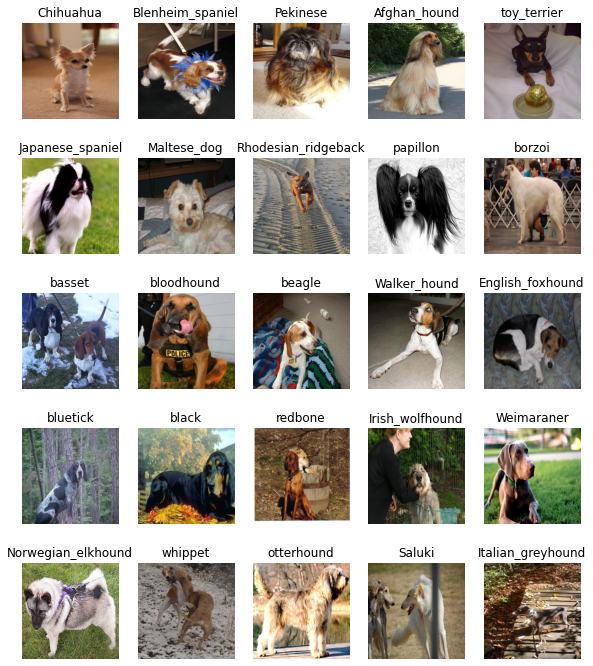

In [3]:
# Lecture des images du dataset
plt.figure(figsize=(10,12))
i = 1
for sub_dir in os.listdir(dataset_dir):
    sub_dir_images = os.listdir(dataset_dir + sub_dir)
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            image = os.path.join(dataset_dir, sub_dir, sub_dir_image)
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(5, 5, i)
            plt.axis('off')
            race = sub_dir.split('-')[1]
            plt.title(race)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

On utilise la méthode image_dataset_from_factory pour charger le jeu de données d'entrainement (train_ds) puis notre jeu de validation (val_ds) sans monopoliser toute la mémoire. En effet l'objet retourné permet d'utiliser un système de batchs de 32 images.

In [4]:
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


On peut vérifier les labels issus du jeu d'entrainement : on a 20580 images classées dans 120 races. On a 80% des images (16464) pour le jeu d'entrainement, et donc 20% (4116) à charger pour le jeu de validation.

In [6]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih_Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

On vérifie les dimensions de l'objet retourné sur la première itération du batch

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


On fait un prefetch des données pour éviter des problèmes d'I/O

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

On va créer notre premier modèle, en s'inspirant du modèle VGG étudié en cours. 

In [8]:
model = Sequential()  # Création d'un réseau de neurones vide

model.add(Input(shape=(height, width, 3)))

model.add(Rescaling(1./255)),
    
# Ajout de la première couche de convolution, suivie d'une couche ReLU
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# Ajout de la deuxième couche de pooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
model.add(Dense(512, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
model.add(Dense(256, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
model.add(Dense(len(class_names), activation='softmax'))

On compile le modèle en fixant l'optimizer Adam (une extension de la descente de gradient classique, populaire en Deep Learning pour ses performances : voir https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) et la fonction de perte SparseCategoricalCrossentropy, car elle est recommandée vis à vis de la fonction CategoricalCrossentropy dans le cas où nos labels sont exclusifs les uns avec les autres.

In [9]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Voici donc à quoi ressemble le modèle compilé :

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

On lance maintenant l'entrainement sur 10 epochs

In [5]:
epochs = 10

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
515/515 [==============================] - 1616s 3s/step - loss: 22.3891 - accuracy: 0.0108 - val_loss: 4.7859 - val_accuracy: 0.0104
Epoch 2/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7859 - accuracy: 0.0123 - val_loss: 4.7865 - val_accuracy: 0.0104
Epoch 3/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7860 - accuracy: 0.0120 - val_loss: 4.7864 - val_accuracy: 0.0104
Epoch 4/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7859 - accuracy: 0.0114 - val_loss: 4.7869 - val_accuracy: 0.0104
Epoch 5/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7860 - accuracy: 0.0121 - val_loss: 4.7866 - val_accuracy: 0.0104
Epoch 6/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7860 - accuracy: 0.0121 - val_loss: 4.7868 - val_accuracy: 0.0104
Epoch 7/10
515/515 [==============================] - 65s 126ms/step - loss: 4.7861 - accuracy: 0.0119 - val_loss: 4.7868 - val_ac

J'écris une fonction permettant d'afficher des graphiques en fonction de l'historique des performances sur les epochs, car cette fonction nous sera encore utile plus tard.

In [11]:
def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

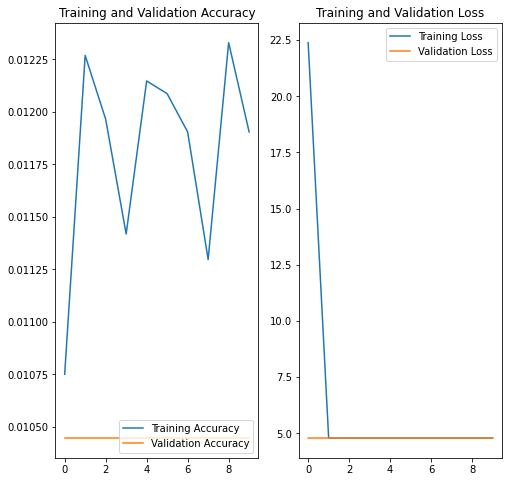

In [12]:
show_perfs(history, epochs)

Le résultat est vraiment très mauvais ! Pour réduire la difficulté d'apprentissage de mon modèle, je vais réduire mon jeu de données à seulement 12 races de chien (10% des données).

Pour optimiser mes données, je choisi les races de chiens pour lesquelles je dispose du plus grand nombre d'images.

In [7]:
nb_classes = 12

In [7]:
# Comptage des images du dataset
dataset_dir = "./images/"
count = {}
for sub_dir in os.listdir(dataset_dir):
    sub_dir_images = os.listdir(dataset_dir + sub_dir)
    race = sub_dir.split('-')[1]
    count[race] = len(sub_dir_images)
c = 0
for race, nb in sorted(count.items(), key=lambda item: item[1], reverse=True):
    print(race, ":", nb)
    c = c + 1
    if c == nb_classes:
        break

Maltese_dog : 252
Afghan_hound : 239
Scottish_deerhound : 232
Pomeranian : 219
Irish_wolfhound : 218
Bernese_mountain_dog : 218
Samoyed : 218
Shih_Tzu : 214
Great_Pyrenees : 213
Leonberg : 210
basenji : 209
Tibetan_terrier : 206


J'ai donc déplacé les images pour ces 12 races dans un répertoire distinct, sur lequel je réinitialise mes jeux d'entrainement et de validation.

In [8]:
dataset_12 = "./images_12/"
train_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 2648 files belonging to 12 classes.
Using 2119 files for training.
Found 2648 files belonging to 12 classes.
Using 529 files for validation.


In [18]:
model_12 = Sequential([
  Input(shape=(height, width, 3)),
  Rescaling(1./255),
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(nb_classes, activation='softmax')
])

Puis je créé une fonction pour le compiler, en afficher le résumé, lancer l'entrainement sur 10 epochs et pour finir afficher ses performances :

In [9]:
def compile_train_show_perfs(f_model, f_train_ds, f_val_ds, f_epochs):
  f_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  f_model.summary()
  f_history = f_model.fit(
    f_train_ds,
    validation_data=f_val_ds,
    epochs=f_epochs
  )
  show_perfs(f_history, f_epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 32)       

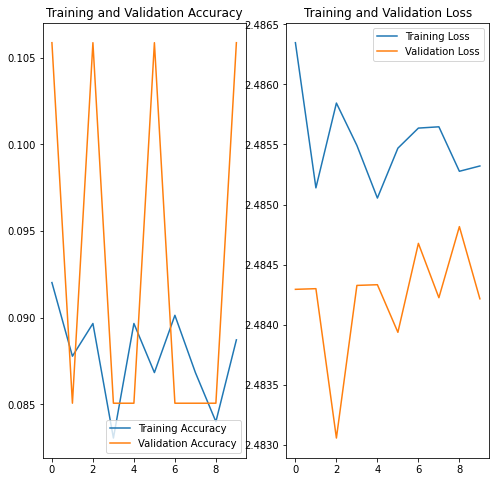

In [17]:
compile_train_show_perfs(model_12, train_12, val_12, epochs)

Les résultats sont meilleurs, mais toujours pas très bons, je vais donc chercher à réaliser une augmentation de données en ajoutant des étapes préliminaires à mon modèle.

J'ajoute donc un "flip" (symétrie), une rotation aléatoire et un zoom aléatoire.

In [19]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(height, width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

Voici un exemple de ce que produit cette augmentation sur une image :

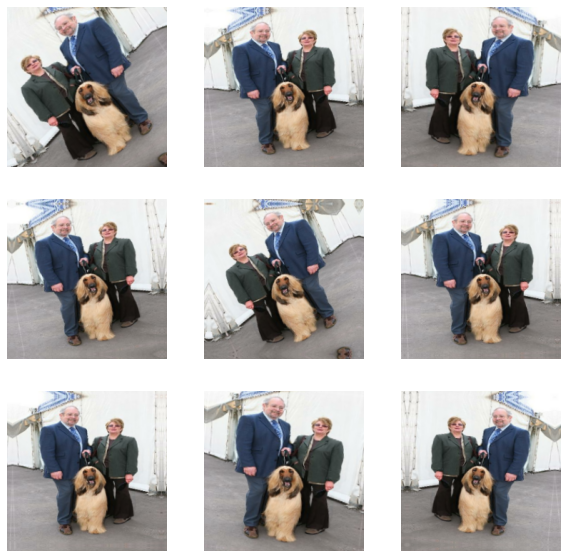

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_12.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

J'ajoute donc ces étapes d'augmentation des données à mon modèle précédent.

In [20]:
model_augmented = Sequential([
  Input(shape=(height, width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(nb_classes, activation='softmax')
])

J'appelle ma fonction pour le compiler, afficher le résumé, lancer l'entrainement sur 10 epochs et afficher ses performances :

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 256)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

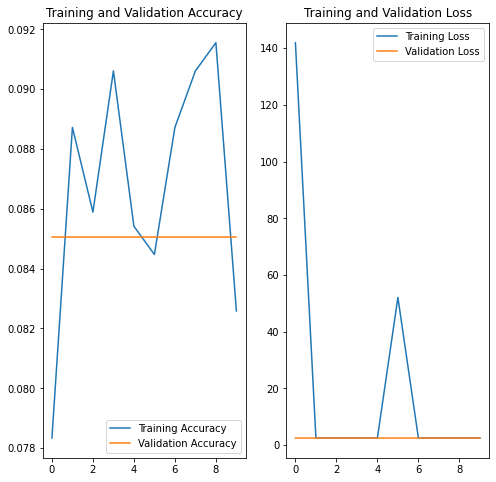

In [20]:
compile_train_show_perfs(model_augmented, train_12, val_12, epochs)

On ne constate pas d'amélioration des performances. On va un peu plus loin en testant d'autres types d'augmenation des données : translation, contraste.

In [9]:
data_augmentation_2 = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 3)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

On remplace donc l'augmentation de données précédente dans le modèle et on relance l'entrainement.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 256)     7168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 128)     295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

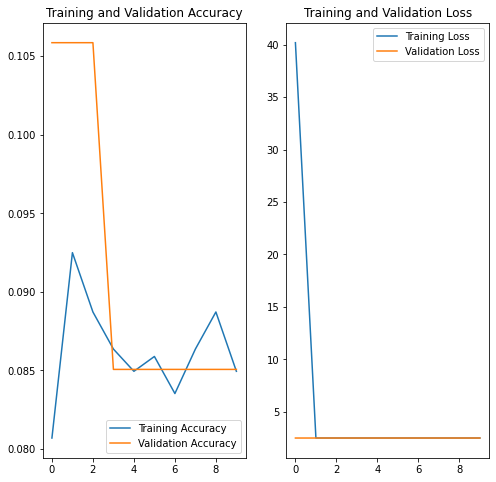

In [22]:
model_augmented_2 = Sequential([
  Input(shape=(height, width, 3)),
  data_augmentation_2,
  Rescaling(1./255),
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(nb_classes, activation='softmax')
])
compile_train_show_perfs(model_augmented_2, train_12, val_12, epochs)

Je vais réessayer en utilisant les images du dataset en noir et blanc.

In [10]:
train_12_bw = image_dataset_from_directory(
  dataset_12,
  color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_12_bw = image_dataset_from_directory(
  dataset_12,
  color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 2648 files belonging to 12 classes.
Using 2119 files for training.
Found 2648 files belonging to 12 classes.
Using 529 files for validation.


J'ai donc maintenant un ensemble d'images avec 1 "channel" au lieu de 3 précédemment.

In [11]:
for image_batch, labels_batch in train_12_bw:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 1)
(32,)


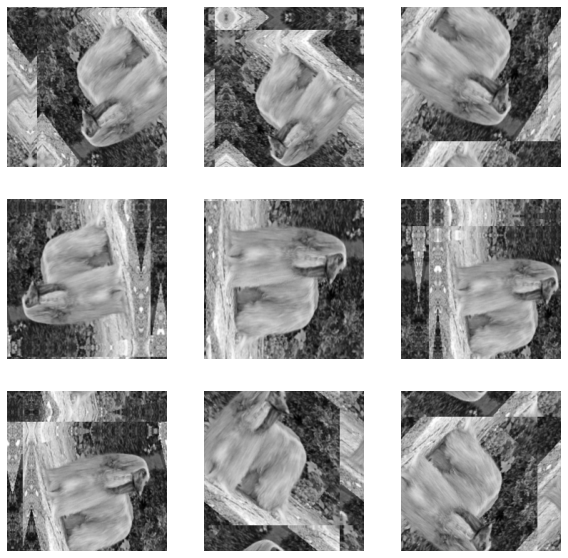

In [12]:
data_augmentation_bw = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 1)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

plt.figure(figsize=(10, 10))
plt.gray()
for images, _ in train_12_bw.take(1):
    for i in range(9):
        augmented_images = data_augmentation_bw(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(augmented_images[0]), cmap='gray')
        plt.axis("off")

In [53]:
for layer in data_augmentation_bw.layers:
    print(layer.input_shape, ">", layer.output_shape)

(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 1)


In [13]:
model_augmented_bw = Sequential([
  Input(shape=(height, width, 1)),
  data_augmentation_bw,
  Rescaling(1./255),
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(nb_classes, activation='softmax')
])

In [55]:
for layer in model_augmented_bw.layers:
    print(layer.input_shape, ">", layer.output_shape)

(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 1)
(None, 224, 224, 1) > (None, 224, 224, 256)
(None, 224, 224, 256) > (None, 112, 112, 256)
(None, 112, 112, 256) > (None, 112, 112, 128)
(None, 112, 112, 128) > (None, 56, 56, 128)
(None, 56, 56, 128) > (None, 401408)
(None, 401408) > (None, 512)
(None, 512) > (None, 256)
(None, 256) > (None, 12)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

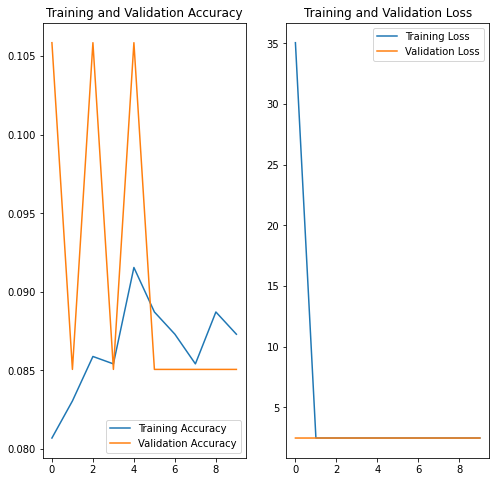

In [15]:
compile_train_show_perfs(model_augmented_bw, train_12_bw, val_12_bw, epochs)

On arrive aux même résultats en noir et blanc. Je vais maintenant chercher à optimiser les hyper-paramètres du modèle.

In [11]:
def model_builder(hp):

    # on cherche à optimiser les 2 couches Conv2D
    hp_filters_1 = hp.Choice('num_filters_1', values=[32, 64, 64], default=32)
    hp_filters_2 = hp.Choice('num_filters_2', values=[16, 32, 64], default=16)
    hp_activation_1 = hp.Choice('dense_activation_1',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')
    hp_activation_2 = hp.Choice('dense_activation_2',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')
    
    # on cherche à optimiser les 2 couches Dense
    hp_units_1 = hp.Int('units_1', min_value=128, max_value=256, step=32)
    hp_units_2 = hp.Int('units_2', min_value=128, max_value=256, step=32)
    hp_activation_3 = hp.Choice('dense_activation_3',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')
    hp_activation_4 = hp.Choice('dense_activation_4',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')

    # on cherche à optimiser la compilation du modèle
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5,
                                max_value=1e-2, sampling='LOG', default=1e-3)

    model = Sequential([
      Input(shape=(height, width, 3)),
      data_augmentation_2,
      Rescaling(1./255),
      Conv2D(hp_filters_1, (3, 3), padding='same', activation=hp_activation_1),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Conv2D(hp_filters_2, (3, 3), padding='same', activation=hp_activation_2),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Flatten(),
      Dense(units=hp_units_1, activation=hp_activation_3),
      Dense(units=hp_units_2, activation=hp_activation_4),
      Dense(nb_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    
    return model

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner',
                     project_name='dogs',
                     overwrite = True)

In [13]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

Pour utiliser le Keras Tuner, je dois récupérer les images en mémoire

In [14]:
img_train = None
label_train = None
for image_batch, labels_batch in tqdm(train_12):
    if img_train == None:
        img_train = image_batch
        label_train = labels_batch
    else:
        img_train = tf.concat(axis=0, values = [img_train, image_batch])
        label_train = tf.concat(axis=0, values = [label_train, labels_batch])
  
print("img_train:", img_train.shape)
print("label_train:", label_train.shape)

100%|██████████| 67/67 [00:03<00:00, 22.06it/s]

img_train: (2119, 224, 224, 3)
label_train: (2119,)


In [15]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.24764150381088257

Best val_accuracy So Far: 0.27358490228652954
Total elapsed time: 00h 06m 49s
INFO:tensorflow:Oracle triggered exit


On récupère les meilleurs hyperparamètres

In [17]:
best_hps.values

{'dense_activation_1': 'relu',
 'dense_activation_2': 'relu',
 'dense_activation_3': 'sigmoid',
 'dense_activation_4': 'tanh',
 'learning_rate': 0.0001993818166638881,
 'num_filters_1': 64,
 'num_filters_2': 16,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_1': 160,
 'units_2': 224}

On essaie d'entrainer le modèle avec ces hyper paramètres.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 16)      9232      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

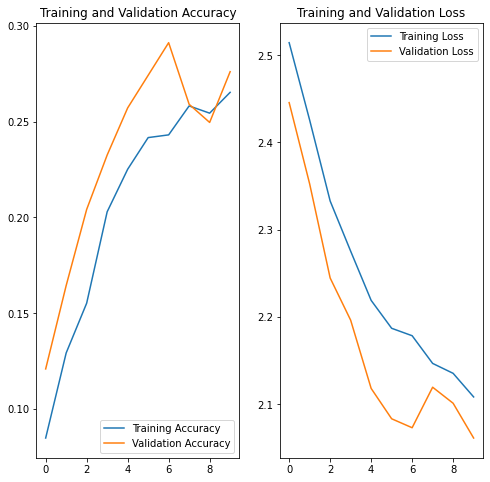

In [18]:
model_opt = Sequential([
      Input(shape=(height, width, 3)),
      data_augmentation_2,
      Rescaling(1./255),
      Conv2D(64, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Conv2D(16, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Flatten(),
      Dense(units=160, activation='sigmoid'),
      Dense(units=224, activation='tanh'),
      Dense(nb_classes, activation='softmax')
    ])
model_opt.compile(optimizer=Adam(learning_rate=0.0001993818166638881),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_opt.summary()
history_opt = model_opt.fit(
  train_12,
  validation_data=val_12,
  epochs=epochs
)
show_perfs(history_opt, epochs)

On constate une très nette amélioration des résultats avec ces paramètres optimisés !
Je regrette de ne pas disposer de suffisament de mémoire pour tester des valeurs plus grandes sur certains paramètres, notamment pour le nombre de filtres sur les couches de convolution.

Au vu de la courbe qui continue de croitre, je teste avec 50 epochs.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 16)      9232      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

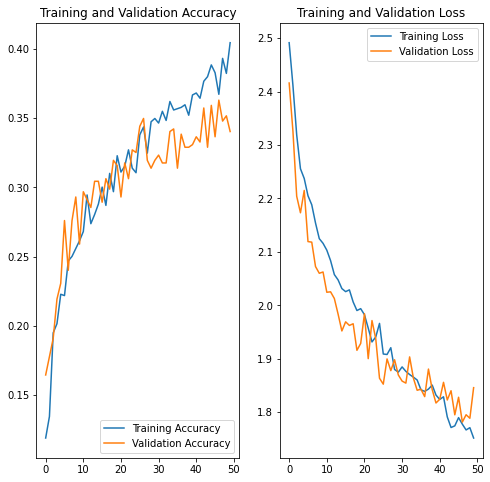

In [19]:
model_opt = Sequential([
      Input(shape=(height, width, 3)),
      data_augmentation_2,
      Rescaling(1./255),
      Conv2D(64, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Conv2D(16, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Flatten(),
      Dense(units=160, activation='sigmoid'),
      Dense(units=224, activation='tanh'),
      Dense(nb_classes, activation='softmax')
    ])
model_opt.compile(optimizer=Adam(learning_rate=0.0001993818166638881),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_opt.summary()
history_opt = model_opt.fit(
  train_12,
  validation_data=val_12,
  epochs=50
)
show_perfs(history_opt, 50)

Avec 50 epochs, le modèle atteint un score allant jusqu'à 36% d'accuracy, ce qui est le meilleur score atteint depuis le début.

Pour finir, je teste le même paramétrage sur le jeu de données comportant 120 espèces.

In [10]:
model_opt_50 = Sequential([
      Input(shape=(height, width, 3)),
      data_augmentation_2,
      Rescaling(1./255),
      Conv2D(64, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Conv2D(16, (3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      Flatten(),
      Dense(units=160, activation='sigmoid'),
      Dense(units=224, activation='tanh'),
      Dense(len(class_names), activation='softmax')
    ])
model_opt_50.compile(optimizer=Adam(learning_rate=0.0001993818166638881),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_opt_50.summary()
history_opt_50 = model_opt_50.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)
show_perfs(history_opt_50, 50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      9232      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

NameError: ignored

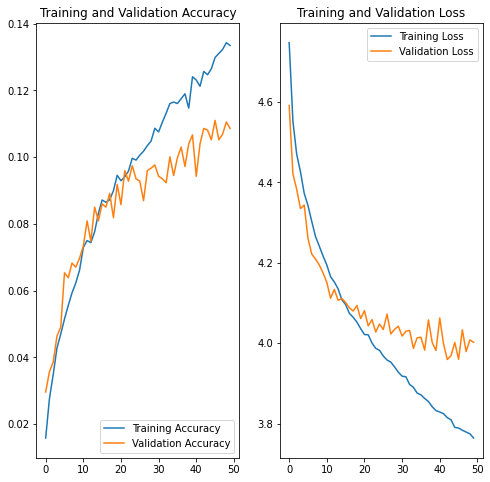

In [12]:
show_perfs(history_opt_50, 50)

Même si les résultats sont beaucoup moins bons qu'avec seulement 12 classes à prédire, on voit que l'optimisation des hyper-paramètres réalisées sur 10% des données a tout de même permis une amélioration de l'accuracy de façon significative.